In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Read the data
data = pd.read_csv("Japan earthquakes 2001 - 2018.csv")

#Process time features
data["time"] = pd.to_datetime(data["time"])
data.sort_values(by="time", inplace=True)
data["year"] = data["time"].dt.year
data["month"] = data["time"].dt.month
data["day"] = data["time"].dt.day
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute

#Select features and target
selected_features = ["year", "month", "day", "hour", "minute", "depth", "gap", "nst", "magNst"]
targets = ["latitude", "longitude", "mag"]

#Filter data with magnitude greater than 5.5
data = data[data["mag"] > 5.5]

#Clean data by removing missing values
data_clean = data.dropna(subset=selected_features + targets)

#Prepare feature matrix X and target y
X = data_clean[selected_features]
y = data_clean[targets]

#Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
MAE: 0.6411522940276724
MSE: 0.835045065140945
R2 Score: 0.6792112325770395


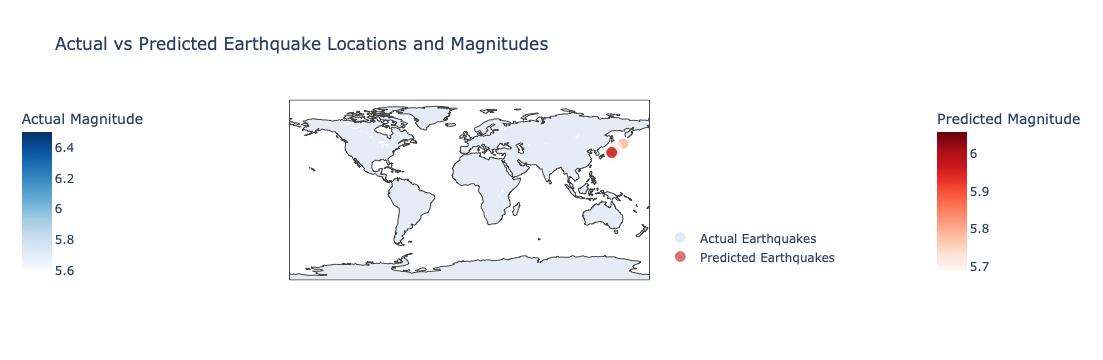

/var/folders/w2/_1tnpyv54znf28ppq1jgwnzr0000gn/T/ipykernel_44649/1992293508.py:85: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




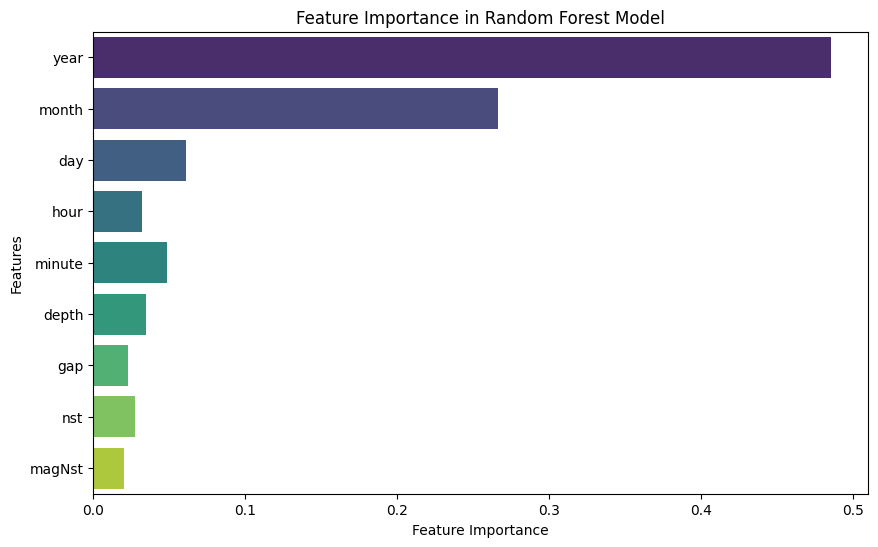

In [ ]:
#Train RandomForest model
rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    "n_estimators": [100, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
rf_search = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring="neg_mean_squared_error", verbose=1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

#Predict
y_pred_rf = best_rf.predict(X_test)

#Evaluate the model
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

#Visualize earthquake locations and magnitudes using Plotly

def visualize_with_plotly(actual_df, pred_df):
    fig = go.Figure()
    
    # Actual earthquake data (blue gradient)
    fig.add_trace(go.Scattergeo(
        lon=actual_df["longitude"],
        lat=actual_df["latitude"],
        text=actual_df["mag"],
        marker=dict(
            size=actual_df["mag"] * 2,
            color=actual_df["mag"],
            colorscale="Blues",
            colorbar=dict(title="Actual Magnitude", x=-0.1),
            opacity=0.6
        ),
        mode="markers",
        name="Actual Earthquakes"
    ))
    
    # Predicted earthquake data (red gradient)
    fig.add_trace(go.Scattergeo(
        lon=pred_df["longitude"],
        lat=pred_df["latitude"],
        text=pred_df["mag"],
        marker=dict(
            size=pred_df["mag"] * 2,
            color=pred_df["mag"],
            colorscale="Reds",
            colorbar=dict(title="Predicted Magnitude", x=1.1),
            opacity=0.6
        ),
        mode="markers",
        name="Predicted Earthquakes"
    ))
    
    fig.update_layout(
        title="Actual vs Predicted Earthquake Locations and Magnitudes",
        geo=dict(
            scope="world",
            showland=True
        ),
        legend=dict(
            x=0.75, 
            y=0.05,
            bgcolor="rgba(255, 255, 255, 0.5)"
        )
    )
    
    fig.show()

actual_df = y_test.copy()
pred_df = pd.DataFrame(y_pred_rf, columns=["latitude", "longitude", "mag"])
visualize_with_plotly(actual_df, pred_df)

#Plot feature importance
feature_importances = best_rf.feature_importances_
feature_names = selected_features

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

#Visualize a decision tree
tree = best_rf.estimators_[0]  # Select the first tree in the Random Forest

dot_data = export_graphviz(
    tree,
    feature_names=selected_features,
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save as a file

# Display the decision tree
graph.view()

'decision_tree.pdf'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestRegressor(random_state=42)

param_grid_rf = {
    "n_estimators": [300, 500, 800],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['auto', 'sqrt', 0.8],
    "bootstrap": [True, False]
}

rf_search = GridSearchCV(
    rf_model,
    param_grid_rf,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("Best RF Parameters:", rf_search.best_params_)